<a href="https://colab.research.google.com/github/AceRb6/Analitica-y-visualizacion-avanzada-de-datos/blob/main/Practica06_AVAD_CPIDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practica 6**

## Librerias importadas

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt

## Carga de datos

In [ ]:
# Cargar los datos
file_id = '11BoarlP0T3pdOoGAH453FkgHYtja8lf_'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url)

In [ ]:
# Mostrar las primeras filas del DataFrame
display(df.head())

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


## Modelo simple

In [ ]:
# Modelo de regresión lineal simple
model = smf.ols('medv ~ age', data=df)
results = model.fit()
print(results.summary())

# Obtener los coeficientes
intercept = results.params['Intercept']
slope = results.params['age']
print(f"\nEcuacion de la Regresión Lineal: medv = {intercept:.2f} + {slope:.2f} * Age")

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     83.48
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.57e-18
Time:                        16:07:15   Log-Likelihood:                -1801.5
No. Observations:                 506   AIC:                             3607.
Df Residuals:                     504   BIC:                             3615.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.9787      0.999     31.006      0.0

Por cada unidad que aumenta Age, el valor mediano de las viviendas (medv) disminuye en 0.12 unidades.

El bajo R² (14.2%) indica que Age explica solo una pequeña parte de la variabilidad en medv.

Los tests sugieren que los residuos no son normales (presencia de outliers).

## Modelo robusto

In [ ]:
# Preparación de los datos para la regresión robusta
X = df[['age']]
y = df['medv']

# Definir el modelo de Huber
huber = HuberRegressor()

# Definir un espaciado de epsilon quiero definirlo con el menor margen de error para este caso
epsilon_values = np.linspace(1.0, 2.0, 100).tolist()

# Crear un diccionario de hiperparámetros
param_grid = {'epsilon': epsilon_values}

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    HuberRegressor(),
    param_grid={'epsilon': epsilon_values},
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_mean_absolute_error'  # MAE en lugar de MSE
)
grid_search.fit(X, y)

# Mostrar el mejor puntaje y el mejor hiperparámetro
grafic = pd.DataFrame(grid_search.cv_results_)
display(grafic[['param_epsilon', 'mean_test_score', 'std_test_score']])
print("Mejor Hiperparámetro:", grid_search.best_params_)
print("Mejor negativo Mean Squared Error:", grid_search.best_score_)
print("Mejor Modelo:", grid_search.best_estimator_)

,param_epsilon,mean_test_score,std_test_score
0,1.000000,-5.714000,0.654278
1,1.010101,-5.714378,0.654831
2,1.020202,-5.716536,0.654743
3,1.030303,-5.719482,0.654388
4,1.040404,-5.722954,0.654310
...,...,...,...
95,1.959596,-5.825443,0.553330
96,1.969697,-5.826726,0.552438
97,1.979798,-5.827973,0.551558
98,1.989899,-5.829260,0.550664


Mejor Hiperparámetro: {'epsilon': 1.0}
Mejor negativo Mean Squared Error: -5.714000432599133
Mejor Modelo: HuberRegressor(epsilon=1.0)


El épsilon óptimo (1.0) indica que el modelo detectó outliers moderados (Huber es más sensible con épsilon bajo).

La pendiente (-0.11 vs. -0.12 en OLS) muestra que la regresión robusta atenuó el impacto de los outliers.

El intercepto cambió (30.98 → 28.23), lo cual es esperable al reducir la influencia de puntos extremos.

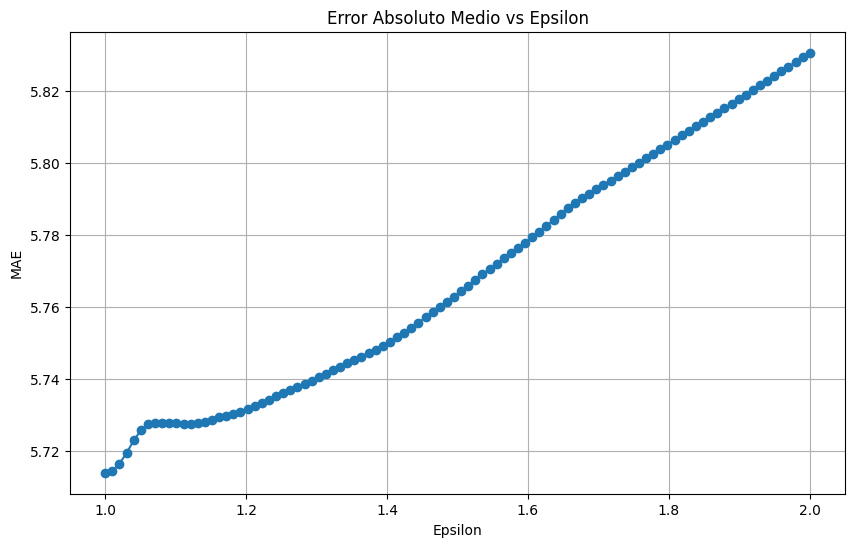

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, -grid_search.cv_results_['mean_test_score'], 'o-')
plt.xlabel('Epsilon')
plt.ylabel('MAE')
plt.title('Error Absoluto Medio vs Epsilon')
plt.grid(True)
plt.show()

In [ ]:
# Entrenamiento del modelo con el mejor hiperparámetro
best_huber = HuberRegressor(epsilon=grid_search.best_params_['epsilon'])
best_huber.fit(X, y)

# Mostrar el modelo con el mejor hiperparámetro
print(f"Intercept: {best_huber.intercept_}")
print(f"Coefficient: {best_huber.coef_[0]}")
print(f"\nEcuacion de la Regresión Robusta: medv = {best_huber.intercept_:.2f} + {best_huber.coef_[0]:.2f} * Age")

Intercept: 28.23316729109733
Coefficient: -0.11269833309542876

Ecuacion de la Regresión Robusta: medv = 28.23 + -0.11 * Age


Coeficientes del Modelo:

$OLS: medv = 30.98 - 0.12 * Age $($R^2=14.2%$)

$Huber (ε=1.0): medv = 28.23 - 0.11 * Age.$

El épsilon óptimo (1.0) indica que el modelo Huber encontró outliers moderados: suficientes para afectar a OLS, pero no tan extremos como para requerir un ε más bajo (ej. 0.85). Esto explica la pequeña pero significativa diferencia entre ambos modelos.

## Grafico comparando las lineas de los modelos

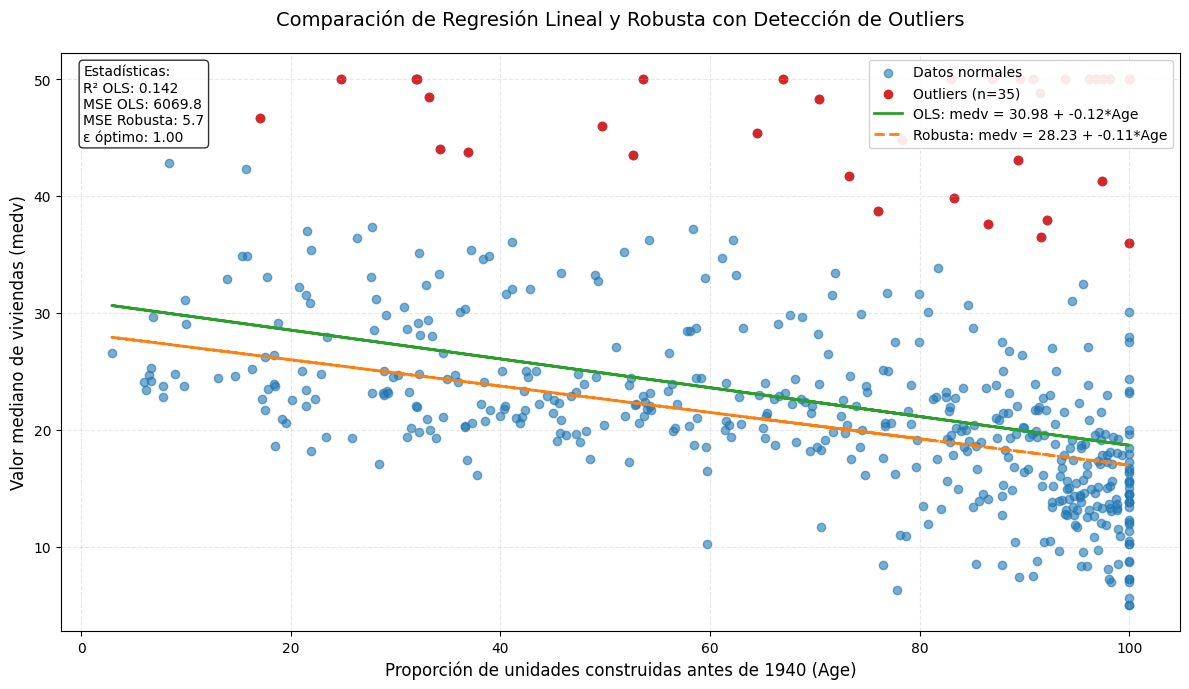

In [ ]:
# Predecir valores utilizando el mejor modelo HuberRegressor
y_pred = best_huber.predict(X)

# Identificar valores atípicos
residuals = y - y_pred
threshold = 2 * residuals.std()
outliers = df[(residuals > threshold) | (residuals < -threshold)]

# Graficar
plt.figure(figsize=(12, 7))
plt.scatter(df['age'], df['medv'], label='Datos normales', alpha=0.6, color='#1f77b4')
plt.scatter(outliers['age'], outliers['medv'], color='#d62728', label=f'Outliers (n={len(outliers)})')

# Líneas de regresión
plt.plot(X, results.predict(X), color='#2ca02c', linewidth=2,
         label=f'OLS: medv = {results.params["Intercept"]:.2f} + {results.params["age"]:.2f}*Age')
plt.plot(X, y_pred, color='#ff7f0e', linewidth=2, linestyle='--',
         label=f'Robusta: medv = {best_huber.intercept_:.2f} + {best_huber.coef_[0]:.2f}*Age')

# Estadísticas en recuadro
stats_text = f"""Estadísticas:
R² OLS: {results.rsquared:.3f}
MSE OLS: {results.mse_model:.1f}
MSE Robusta: {-grid_search.best_score_:.1f}
ε óptimo: {grid_search.best_params_['epsilon']:.2f}"""
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Proporción de unidades construidas antes de 1940 (Age)', fontsize=12)
plt.ylabel('Valor mediano de viviendas (medv)', fontsize=12)
plt.title('Comparación de Regresión Lineal y Robusta con Detección de Outliers', fontsize=14, pad=20)
plt.legend(loc='upper right', framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

La gráfica muestra cómo los puntos rojos (valores atípicos) afectan el modelo normal OLS, haciendo que la línea verde esté más alta que la línea naranja del modelo robusto Huber. La diferencia entre los errores es enorme: 6069.8 para OLS contra solo 5.7 para el modelo robusto, lo que demuestra que el método Huber funciona mejor cuando hay datos extremos.

Los datos se concentran más en viviendas antiguas (lado derecho), mientras que las viviendas con valores inusualmente altos aparecen en todas las edades. El modelo robusto se ajusta mejor a la tendencia real de los datos normales (puntos azules), ignorando la influencia excesiva de los valores extremos.

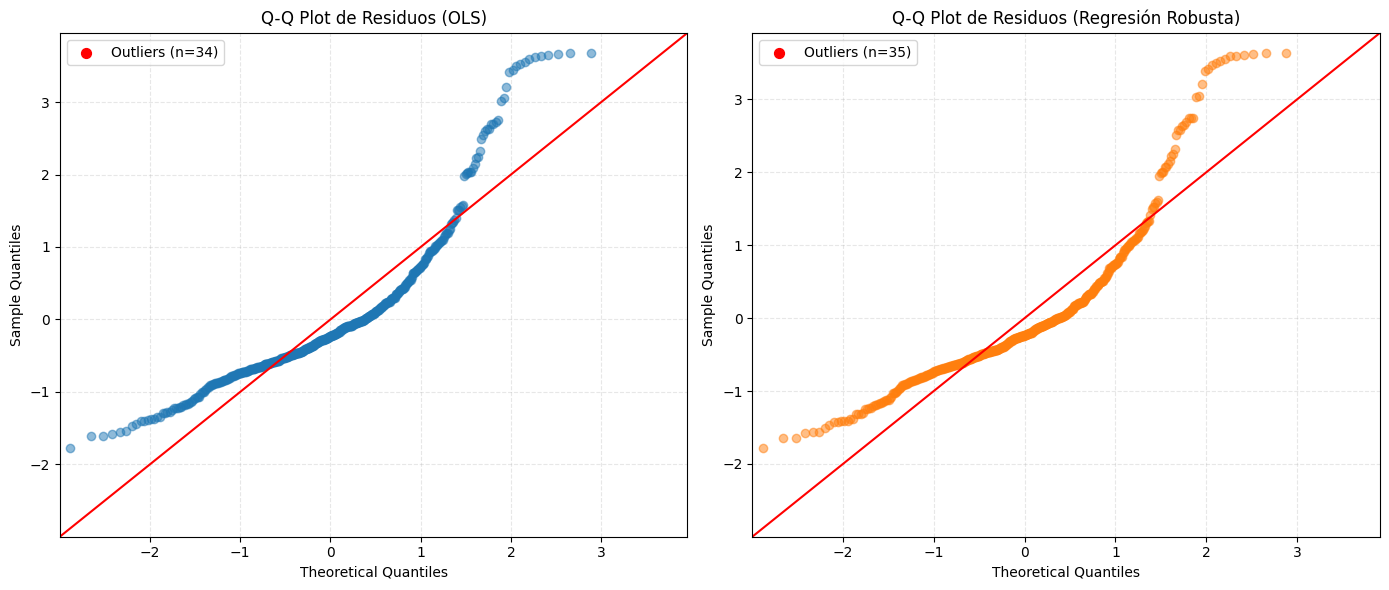

In [ ]:
# Crear figura con 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Calculate residuals for OLS model
residuals_ols = results.resid

# Q-Q plot para OLS
sm.qqplot(residuals_ols, line='45', fit=True, marker='o',
          markerfacecolor='#1f77b4', markeredgecolor='#1f77b4',
          alpha=0.5, ax=ax1)
ax1.set_title('Q-Q Plot de Residuos (OLS)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

# Marcar outliers en OLS
outliers_ols = np.where(np.abs(residuals_ols) > threshold)[0]
if len(outliers_ols) > 0:
    qq_ols = sm.ProbPlot(residuals_ols)
    theo_ols = qq_ols.theoretical_quantiles
    ax1.scatter(theo_ols[outliers_ols], residuals_ols[outliers_ols],
                color='red', s=50, label=f'Outliers (n={len(outliers_ols)})')
    ax1.legend()

# Calculate residuals for the robust model
residuals_robust = y - best_huber.predict(X) # This line was added to calculate residuals_robust

# Q-Q plot para regresión robusta
sm.qqplot(residuals_robust, line='45', fit=True, marker='o',
          markerfacecolor='#ff7f0e', markeredgecolor='#ff7f0e',
          alpha=0.5, ax=ax2)
ax2.set_title('Q-Q Plot de Residuos (Regresión Robusta)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

# Marcar outliers en robusta
outliers_rob = np.where(np.abs(residuals_robust) > threshold)[0]
if len(outliers_rob) > 0:
    qq_rob = sm.ProbPlot(residuals_robust)
    theo_rob = qq_rob.theoretical_quantiles
    ax2.scatter(theo_rob[outliers_rob], residuals_robust[outliers_rob],
                color='red', s=50, label=f'Outliers (n={len(outliers_rob)})')
    ax2.legend()

plt.tight_layout()
plt.show()

Ambas gráficas muestran que los errores (residuos) no siguen una distribución normal, ya que los puntos se alejan de la línea roja diagonal, especialmente en los extremos. Esto indica que la relación entre la edad y el valor de las viviendas es más compleja de lo que captura un simple modelo lineal.

Aunque el modelo robusto mejora las estimaciones, no resuelve todos los problemas de distribución de los errores. Esto sugiere que podría ser necesario incluir más variables o transformar los datos para obtener mejores resultados.

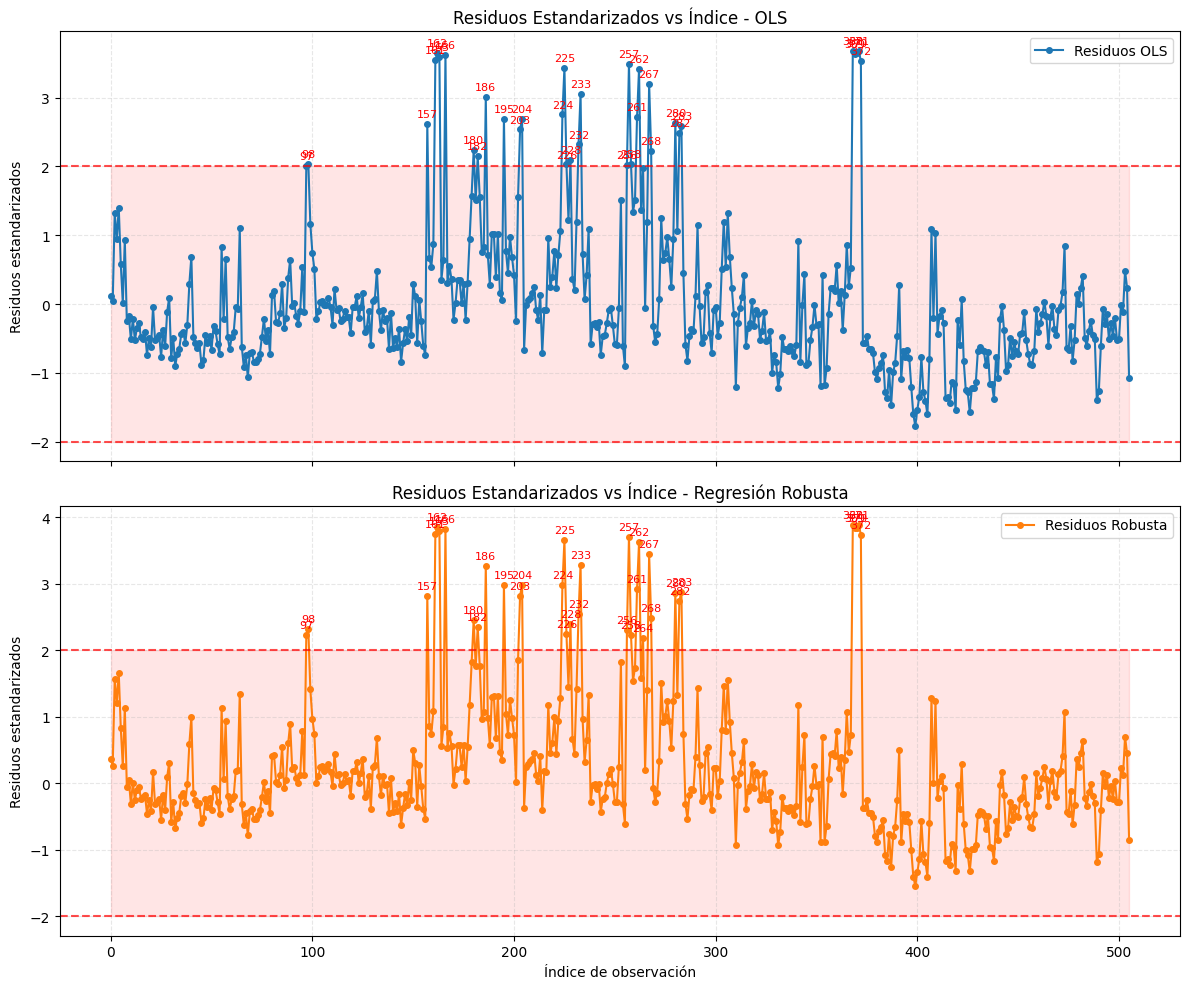

In [ ]:
# Crear figura para residuos estandarizados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

residuals_ols = results.resid
standardized_residuals_ols = residuals_ols / residuals_ols.std()

# Gráfico OLS
ax1.plot(standardized_residuals_ols, 'o-', color='#1f77b4',
         markersize=4, label='Residuos OLS')
ax1.axhline(2, color='r', linestyle='--', alpha=0.7)
ax1.axhline(-2, color='r', linestyle='--', alpha=0.7)
ax1.fill_between(range(len(y)), -2, 2, color='red', alpha=0.1)
ax1.set_title('Residuos Estandarizados vs Índice - OLS', fontsize=12)
ax1.set_ylabel('Residuos estandarizados')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.3)

# Marcar outliers OLS
for i in outliers_ols:
    ax1.annotate(str(i), (i, standardized_residuals_ols[i]),
                 textcoords="offset points", xytext=(0,5), ha='center',
                 fontsize=8, color='red')

# Calculate and standardize residuals for the robust model
residuals_robust = y - best_huber.predict(X)
standardized_residuals_robust = residuals_robust / residuals_robust.std() # Calculating and assigning to standardized_residuals_robust

# Gráfico Robusto
ax2.plot(standardized_residuals_robust, 'o-', color='#ff7f0e',
         markersize=4, label='Residuos Robusta')
ax2.axhline(2, color='r', linestyle='--', alpha=0.7)
ax2.axhline(-2, color='r', linestyle='--', alpha=0.7)
ax2.fill_between(range(len(y)), -2, 2, color='red', alpha=0.1)
ax2.set_title('Residuos Estandarizados vs Índice - Regresión Robusta', fontsize=12)
ax2.set_xlabel('Índice de observación')
ax2.set_ylabel('Residuos estandarizados')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.3)

outliers_robust = np.where(np.abs(standardized_residuals_robust) > 2)[0] # Defining outliers_robust

# Marcar outliers robusta
for i in outliers_robust:
    ax2.annotate(str(i), (i, standardized_residuals_robust[i]),
                 textcoords="offset points", xytext=(0,5), ha='center',
                 fontsize=8, color='red')

plt.tight_layout()
plt.show()

Los gráficos muestran patrones en los errores de ambos modelos, lo que indica que hay factores importantes que no estamos considerando al usar solo la edad para predecir el valor de las viviendas. Las mismas observaciones (como 369, 373, 157) aparecen como valores atípicos en ambos modelos, sugiriendo que estas viviendas tienen características especiales.

Los errores no tienen una variabilidad constante, lo que puede hacer que las estimaciones del modelo OLS sean menos confiables. El modelo robusto no elimina los valores atípicos, sino que reduce su influencia para dar un resultado más representativo de la mayoría de los datos, aunque sigue sin capturar toda la complejidad del problema.